# Урок 6. Градиентный бустинг (AdaBoost)

## Задание 1: Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
# подключим необходимые библиотеки

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt

import numpy as np

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)


In [2]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    #return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])
    return np.sum([eta* coef * alg.predict(X) for alg, coef in zip(trees_list, coef_list)], axis=0)


def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)


def bias(y, z):
    return (y - z)


def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors


def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, max_depth, n_trees):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

    return mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)


def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()


# напишем функцию для построения массивов ошибок
def fit_to_errors(list_trees, list_depth):
    for i in range(len(list_trees)):
        trees, train_errors, test_errors = gb_fit(list_trees[i], list_depth[i], X_train, X_test, y_train, y_test, coefs, eta)
        train_errors, test_errors = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, list_depth[i], list_trees[i])
        list_errors_trees_test.append(test_errors)
        list_errors_trees_train.append(train_errors)
    return list_errors_trees_test, list_errors_trees_train


# напишем функцию для построения массивов ошибок на всех параметрах
def fit_to_errors_all(list_trees, list_depth):
    for i in range(len(list_trees)):
        print(f'===============\n Поиск лучшей метрики на {list_trees[i]} деревьях')
        for k in range(len(list_depth)):
            trees, train_errors, test_errors = gb_fit(list_trees[i], list_depth[k], X_train, X_test, y_train, y_test, coefs, eta)
            train_errors, test_errors = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, list_depth[k], list_trees[i])
            list_errors_trees_test.append(test_errors)
            list_errors_trees_train.append(train_errors)
        print('\n')
    return list_errors_trees_test, list_errors_trees_train


# перепишем функцию построения графиков
def plot_err_log(X_name, X, y_test, y_train):
    plt.xlabel(X_name)
    plt.ylabel('MSE')
    plt.plot(X, y_test, label='test error')
    plt.plot(X, y_train, label='train error')
    plt.legend(loc='upper right')
    plt.xscale('log')
    plt.show()

In [3]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.5



In [4]:
n_trees_array = [1, 5, 10, 30, 50, 100]
n_depth_array = [3, 3, 3, 3, 3, 3]
list_errors_trees_train = []
list_errors_trees_test = []
errors_test, errors_train = fit_to_errors(n_trees_array, n_depth_array)

Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 9925.42414342598
Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 7999.1266050518025
Ошибка алгоритма из 5 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 2070.535163192589
Ошибка алгоритма из 5 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 3106.307322110515
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 1474.138191200028
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 3260.8852919076303
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 1474.138191200028
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 3260.8852919076303
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 1474.138191200028
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 3260.8852919076

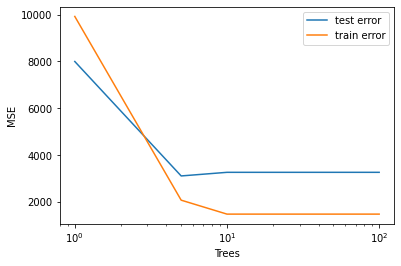

In [5]:
plot_err_log('Trees', n_trees_array, errors_test, errors_train)

In [6]:
n_depth_array = [1, 2, 3, 4, 5, 10, 20, 30, 40]
n_trees_array = [5, 5, 5, 5, 5, 5, 5, 5, 5]
list_errors_trees_train = []
list_errors_trees_test = []
errors_test, errors_train = fit_to_errors(n_trees_array, n_depth_array)

Ошибка алгоритма из 5 деревьев глубиной 1     с шагом 0.5 на тренировочной выборке: 3213.8727760366282
Ошибка алгоритма из 5 деревьев глубиной 1     с шагом 0.5 на тестовой выборке: 2897.06743824756
Ошибка алгоритма из 5 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 2659.0551730674424
Ошибка алгоритма из 5 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 2929.449789118365
Ошибка алгоритма из 5 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 2070.535163192589
Ошибка алгоритма из 5 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 3106.307322110515
Ошибка алгоритма из 5 деревьев глубиной 4     с шагом 0.5 на тренировочной выборке: 1429.036922134387
Ошибка алгоритма из 5 деревьев глубиной 4     с шагом 0.5 на тестовой выборке: 3242.0624462008036
Ошибка алгоритма из 5 деревьев глубиной 5     с шагом 0.5 на тренировочной выборке: 752.4660671049112
Ошибка алгоритма из 5 деревьев глубиной 5     с шагом 0.5 на тестовой выборке: 3477.061211558593
Оши

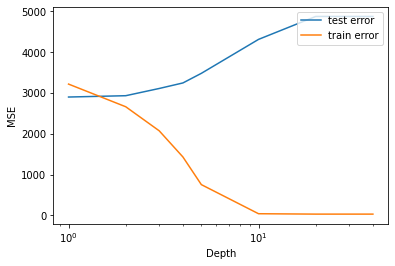

In [7]:
plot_err_log('Depth', n_depth_array, errors_test, errors_train)

Видим, что лучшие показатели были достигнуты на 5 деревьях с глубиной 3. При этом, чем больше деревьев, тем больше переобучение и хуже метрика на тесте.

С другой стороны видим хорошую метрику на 5 деревьях с глубиной 2. Где переобучение минимальное, а метрика на тестовой выборке не далеко уходит от тренировочной.

Поэтому попробуем подобрать на разном количестве деревьев с разной глубиной

In [8]:
n_depth_array = [1, 2, 3, 4, 5, 10, 20, 30, 40]
n_trees_array = [1, 5, 10, 30, 50, 100]
list_errors_trees_train = []
list_errors_trees_test = []

fit_to_errors_all(n_trees_array, n_depth_array)

 Поиск лучшей метрики на 1 деревьях
Ошибка алгоритма из 1 деревьев глубиной 1     с шагом 0.5 на тренировочной выборке: 10972.964432245639
Ошибка алгоритма из 1 деревьев глубиной 1     с шагом 0.5 на тестовой выборке: 8530.800671369443
Ошибка алгоритма из 1 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 10304.728436970525
Ошибка алгоритма из 1 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 7927.638047698497
Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 9925.42414342598
Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 7999.1266050518025
Ошибка алгоритма из 1 деревьев глубиной 4     с шагом 0.5 на тренировочной выборке: 9522.511814316884
Ошибка алгоритма из 1 деревьев глубиной 4     с шагом 0.5 на тестовой выборке: 7828.442635502801
Ошибка алгоритма из 1 деревьев глубиной 5     с шагом 0.5 на тренировочной выборке: 9025.996629443345
Ошибка алгоритма из 1 деревьев глубиной 5     с шагом 0.5 на тес

([8530.800671369443,
  7927.638047698497,
  7999.1266050518025,
  7828.442635502801,
  8162.105748007819,
  8270.62238105886,
  8309.92117117117,
  8309.92117117117,
  8309.92117117117,
  2897.06743824756,
  2929.449789118365,
  3106.307322110515,
  3242.0624462008036,
  3477.061211558593,
  4308.468217310987,
  4870.268378730293,
  4870.268378730293,
  4870.268378730293,
  2841.1477560437697,
  2960.8556536923907,
  3260.8852919076303,
  3498.816047930237,
  3720.012857471281,
  4448.771952718852,
  5017.486858548345,
  5017.486858548345,
  5017.486858548345,
  2841.1477560437697,
  2960.8556536923907,
  3260.8852919076303,
  3498.816047930237,
  3720.012857471281,
  4448.771952718852,
  5017.486858548345,
  5017.486858548345,
  5017.486858548345,
  2841.1477560437697,
  2960.8556536923907,
  3260.8852919076303,
  3498.816047930237,
  3720.012857471281,
  4448.771952718852,
  5017.486858548345,
  5017.486858548345,
  5017.486858548345,
  2841.1477560437697,
  2960.8556536923907,
  326

Видим, что после 10 деревьев и глубиной 1 метрика теста и тренировочная самая лучшая. Это не совсем однозначный результат, чтобы на первом уровне давать лучшую метрику, чем на 2 или 3 уровнях. Но с текущим датасетом имеем то, что есть.